In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import yaml
import platform
import random
import math
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import Bio
from Bio import SeqIO
from collections import defaultdict
from pathlib import Path
from statsmodels.stats.multitest import multipletests
from scipy.stats import fisher_exact, spearmanr, kde
from biopandas.pdb import PandasPdb
from pyRBDome.Classes.CIFAnalyser import *
from pyRBDome.Classes.PDBFinder import *
from pyRBDome.Classes.DataFileParser import *
from pyRBDome.Functions.RBDomeAnalysisCode import *
from pyRBDome.Functions.RBDomeSQL import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['lines.linewidth'] = 0.75
matplotlib.rcParams['axes.linewidth'] = 0.75
matplotlib.rc('ytick',labelsize=14)
matplotlib.rc('xtick',labelsize=14)
matplotlib.rc('axes',labelsize=18)
plt.rcParams['figure.figsize'] = [5, 3]
%matplotlib inline

In [2]:
def sortbyvalue(d):
    """ This function takes a dictionary and generates a list in which the keys are sorted by their value"""
    items = [(v, k) for k, v in list(d.items())]
    items.sort()
    items.reverse() # so largest is first
    items = [(k, v) for v, k in items]
    return items

### Setting the parameters for the job:

In [3]:
settings_file = open('settings.yaml','r')
settings = yaml.load(settings_file,Loader=yaml.FullLoader)

In [4]:
### Parameters:
out_dir = os.path.abspath(settings[0]['general']['out_dir'])
data = os.path.abspath(settings[0]['general']['datafile'])
proteome = os.path.abspath(settings[0]['general']['proteome'])

### Database parameters
database_name = settings[4]['database']['database_name']
database_table = settings[4]['database']['database_table']
processed_table = settings[4]['database']['processed_files_log']

dist_analysis_log = settings[4]['database']['distance_analyses_log']
rna_bindingsite_log = settings[4]['database']['rna_bindingsite_log']

In [5]:
out_dir

'/localdisk/home/openngs/openngs/notebooks/ngs/sander/pyrbdome_full_160823/analysis_results'

# Count tri-peptide motifs

In [6]:
minpeptidelength = 5
kmer_length = 3

### 1. proteome_counter

In [7]:
# Count tri-peptides for whole proteome as control
proteome_counter = defaultdict(int)
for seq_record in SeqIO.parse(proteome, "fasta"): 
    sequence = str(seq_record.seq)
    controlpeptides = (doOpenMSProteinProteaseDigestion(sequence,
                                                        enzyme='Trypsin',
                                                        minlength=minpeptidelength,
                                                        maxlength=29))
    for peptide in controlpeptides:
        for motif in getMotifs(peptide,kmer_length):
            proteome_counter[motif] += 1

### 2. trypsin_peptide_counter and lysc_peptide_counter

In [8]:
# For the in-silico digested peptides as control (Trypsin and Lys-C)
trypsin_peptides = loadTableFromSQLite('trypsin_peptides_with_match_in_pdb',database_name)
trypsin_peptide_counter = defaultdict(int)
for peptide in trypsin_peptides.Peptide:
    for motif in getMotifs(peptide,kmer_length):
        trypsin_peptide_counter[motif] += 1
        
lysc_peptides = loadTableFromSQLite('lys_C_peptides_with_match_in_pdb',database_name)
lysc_peptide_counter = defaultdict(int)
for peptide in lysc_peptides.Peptide:
    for motif in getMotifs(peptide,kmer_length):
        lysc_peptide_counter[motif] += 1

Table 'trypsin_peptides_with_match_in_pdb' successfully loaded from database 'pyrbdome_full.db' 
Table 'lys_C_peptides_with_match_in_pdb' successfully loaded from database 'pyrbdome_full.db' 


### 3. peptide_counter <br> 4. protein_counter

In [9]:
# For RNA-binding peptide list (RBS-ID from the paper) and for corresponding proteins
f = DataFileParser(datafile = data)
cross_linked = f.data
cross_linked = cross_linked.drop_duplicates(subset=["Protein","Peptide"],keep='first')
getProteinSequencesFromFasta(cross_linked,proteome)
#Now counting Tri-peptide motifs:
peptide_counter = defaultdict(int)
protein_counter = defaultdict(int)
tracker = list()
peptide_col_index = list(cross_linked.columns).index("Peptide")
sequence_col_index = list(cross_linked.columns).index("sequence")
for row in range(len(cross_linked.index)):
    peptide = cross_linked.iloc[row,peptide_col_index]
    sequence = cross_linked.iloc[row,sequence_col_index]
    if len(peptide) >= minpeptidelength:    
        for motif in getMotifs(peptide,kmer_length):
            peptide_counter[motif] += 1
        if sequence not in tracker:
            controlpeptides = (doOpenMSProteinProteaseDigestion(sequence,
                                                                enzyme='Trypsin',
                                                                minlength=minpeptidelength,
                                                                maxlength=40))
            for peptide in controlpeptides:
                for motif in getMotifs(peptide,kmer_length):
                    protein_counter[motif] += 1

            tracker.append(sequence)

/localdisk/home/openngs/openngs/packages/pyrbdome-dev-082023/pyRBDome/Classes/DataFileParser.py:62: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data.loc[:,'Peptide'] = self.data.loc[:,'Peptide'].str.replace('\\s*\\([^\\)]+\\)','')


### 5. Random_peptide_counter

In [10]:
# For the random_peptides:
random_peptides = loadTableFromSQLite('random_peptides_with_match_in_pdb',database_name)
random_peptide_counter = defaultdict(int)
for peptide in random_peptides.Peptide:
    for motif in getMotifs(peptide,kmer_length):
        random_peptide_counter[motif] += 1

Table 'random_peptides_with_match_in_pdb' successfully loaded from database 'pyrbdome_full.db' 


## Compare motifs between different datasets: motif_zscores

In [11]:
def compareMotifs(counter_1, counter_2,name_1,name_2):
    motif_zscores = calcMotifZscores(counter_1,counter_2)
    motif_results = pd.DataFrame.from_dict(motif_zscores,orient='index')
    motif_results.columns = ['Z-score']
    motif_results.sort_values(by='Z-score',ascending=False,inplace=True)
    #save copy as text file
    motif_results.to_csv("%s/PeptideMotifs_%s_vs_%s.txt" % \
                         (out_dir,name_1.replace('_counter',''),name_2.replace('_counter','')),sep="\t")
    #make plot
    fig,ax = plt.subplots()
    motif_results.plot(kind='hist',bins=20,ax=ax)
    ax.set_xlabel('Z-score')
    ax.set_xticks(np.arange(-7,8))
    plt.figure(figsize=(1, 1))
    fig.savefig(f"{out_dir}/Z_score_distribution_motifs_{name_1.replace('_counter','')}_vs_{name_2.replace('_counter','')}.pdf" ,dpi=400)

1. proteome_counter
2. trypsin_peptide_counter 
3. lysc_peptide_counter
4. peptide_counter
5. protein_counter
6. Random_peptides_batch_*_counter

### compare with whole proteome:

In [12]:
compareMotifs(counter_1 = peptide_counter, 
              counter_2 = proteome_counter,
              name_1 = 'peptide_counter',
              name_2 = 'proteome_counter')

<Figure size 100x100 with 0 Axes>

### compare with their corresponding proteins:

In [13]:
compareMotifs(counter_1 = peptide_counter, 
              counter_2 = protein_counter,
              name_1 = 'peptide_counter',
              name_2 = 'protein_counter')

<Figure size 100x100 with 0 Axes>

### compare with trypsin in-silico digested peptides:

In [14]:
compareMotifs(counter_1 = peptide_counter, 
              counter_2 = trypsin_peptide_counter,
              name_1 = 'peptide_counter',
              name_2 = 'trypsin_peptide_counter')

<Figure size 100x100 with 0 Axes>

### compare with lysc in-silico digested peptides:

In [15]:
compareMotifs(counter_1 = peptide_counter, 
              counter_2 = lysc_peptide_counter,
              name_1 = 'peptide_counter',
              name_2 = 'lysc_peptide_counter')

<Figure size 100x100 with 0 Axes>

### compare trypsin in-silico with lysc in-silico digested peptides:

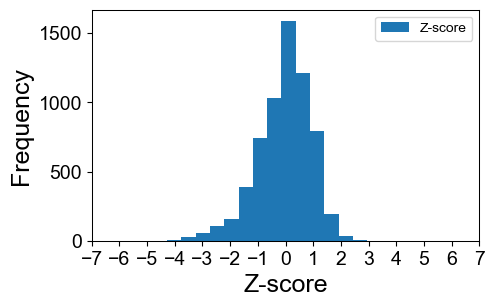

<Figure size 100x100 with 0 Axes>

In [16]:
compareMotifs(counter_1 = trypsin_peptide_counter, 
              counter_2 = lysc_peptide_counter,
              name_1 = 'trypsin_peptide_counter',
              name_2 = 'lysc_peptide_counter')

### compare with random_peptides:

In [17]:
compareMotifs(counter_1 = peptide_counter, 
              counter_2 = random_peptide_counter,
              name_1 = 'peptide_counter',
              name_2 = 'random_peptide_counter')

<Figure size 100x100 with 0 Axes>

### Also calulating p-values for enriched motifs:

In [18]:
def calculate_p_value(test_count_motif, control_count_motif, motif_to_analyze,alpha=0.01, method='fdr_bh'):
    # Get the counts of the motif in the test and control datasets
    test_count_M = test_count_motif.get(motif_to_analyze, 0)
    control_count_M = control_count_motif.get(motif_to_analyze, 0)

    # Calculate total counts for both datasets
    total_test_count = sum(test_count_motif.values())
    total_control_count = sum(control_count_motif.values())

    # Construct the contingency table
    contingency_table = [
        [test_count_M, total_test_count - test_count_M],
        [control_count_M, total_control_count - control_count_M]
    ]

    # Perform Fisher's exact test
    odds_ratio, p_value = fisher_exact(contingency_table)

    # Correct the p-value for multiple testing using the specified method
    p_values_corrected = multipletests([p_value], alpha=alpha, method=method)[1]

    return p_values_corrected[0]

### Calculate p-values relative to randomly selected peptides:

In [19]:
motif_p_values = defaultdict(float)

for motif in peptide_counter:
    p_value = calculate_p_value(peptide_counter,random_peptide_counter,motif)
    log_norm_p_value = -np.log10(p_value)
    motif_p_values[motif] = log_norm_p_value

In [20]:
sortbyvalue(motif_p_values)[:10]

[('SRS', 15.910554301774358),
 ('FVG', 10.697200012573143),
 ('RSR', 7.002112838900322),
 ('IFV', 6.682466439212411),
 ('GGG', 6.531319081784249),
 ('AFV', 6.418923372960908),
 ('GNL', 5.822329796118666),
 ('GRG', 5.587929156515818),
 ('AAA', 5.3154705545667005),
 ('FIG', 5.259792520233085)]

### Make bar plot of top 20 enriched motifs in the peptide sequences:

In [21]:
# Create a Pandas DataFrame from the dictionary
df = pd.DataFrame.from_dict(motif_p_values, orient='index', columns=['p-value'])

In [22]:
df

p-value
LKK  0.379291
KKE  2.295973
KED  0.472844
EDI  0.111039
DIQ -0.000000
..        ...
KIY  0.301300
MKM  0.301300
IRC  0.602607
MKG  2.109248
KRW  0.301300

[7999 rows x 1 columns]

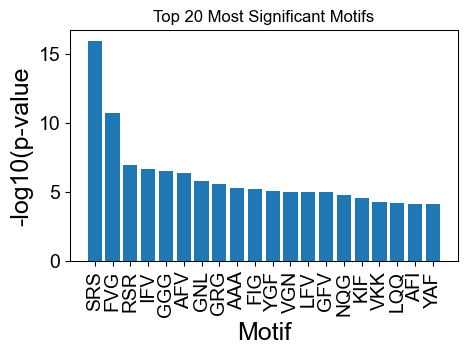

In [23]:
# Sort the DataFrame by p-value in ascending order
df = df.sort_values(by='p-value', ascending=False)

# Select the top 20 most significant motifs
top_20_motifs = df.iloc[:20, :]

# Create a bar plot of the top 20 most significant motifs
plt.bar(top_20_motifs.index, top_20_motifs['p-value'])
# Get the tick labels
tick_labels = plt.xticks()[1]

# Rotate the tick labels
for tick_label in tick_labels:
    tick_label.set_rotation(90)
plt.xlabel('Motif')
plt.ylabel('-log10(p-value')
plt.title('Top 20 Most Significant Motifs')
plt.savefig(f"{out_dir}/Top20_enriched_motifs_in_peptides.pdf",dpi=400)

### Calculate p-values relative to trypsin digested peptides:

In [24]:
motif_p_values = defaultdict(float)

for motif in peptide_counter:
    p_value = calculate_p_value(peptide_counter,trypsin_peptide_counter,motif)
    log_norm_p_value = -np.log10(p_value)
    motif_p_values[motif] = log_norm_p_value

In [25]:
sortbyvalue(motif_p_values)[:10]

[('RGF', 16.622523215948142),
 ('SSS', 16.038673813496153),
 ('EEE', 13.898710897487097),
 ('VKK', 13.687468873294867),
 ('SRG', 12.007665731591237),
 ('RSR', 11.211336885062186),
 ('RGG', 10.948890186297989),
 ('FVG', 10.905722584312045),
 ('FGF', 10.684454424331863),
 ('RGL', 10.420548174173645)]

### Make bar plot of top 20 enriched motifs in the peptide sequences:

In [26]:
# Create a Pandas DataFrame from the dictionary
df = pd.DataFrame.from_dict(motif_p_values, orient='index', columns=['p-value'])

In [27]:
df

p-value
LKK  5.537665
KKE  2.510453
KED  5.806102
EDI  1.907073
DIQ -0.000000
..        ...
KIY -0.000000
MKM -0.000000
IRC -0.000000
MKG -0.000000
KRW -0.000000

[7999 rows x 1 columns]

In [28]:
# Sort the DataFrame by p-value in ascending order
df = df.sort_values(by='p-value', ascending=False)

# Select the top 20 most significant motifs
top_20_motifs = df.iloc[:20, :]

# Create a bar plot of the top 20 most significant motifs
plt.bar(top_20_motifs.index, top_20_motifs['p-value'])
# Get the tick labels
tick_labels = plt.xticks()[1]

# Rotate the tick labels
for tick_label in tick_labels:
    tick_label.set_rotation(90)
plt.xlabel('Motif')
plt.ylabel('-log10(p-value')
plt.title('Top 20 Most Significant Motifs')
plt.savefig(f"{out_dir}/Top20_enriched_motifs_in_peptides_trypsin_control.pdf",dpi=400)

### Make bar plot of top 20 enriched motifs in the known RBPs:

In [29]:
known_motif_p_values = pd.read_csv(f"{out_dir}/Motif_p_values.txt",sep="\t",header=0,index_col=0)
known_motif_p_values.sort_values(by='p-value',ascending=False,inplace=True)

In [30]:
known_motif_p_values.head()

motif  counts    p-value
13   KRK      36  20.004490
6    KKR      28  12.674287
10   RRL      27  11.272407
58   RKT      18  10.131912
63   PRR      21   9.804212

In [31]:
# Select the top 20 most significant motifs
top_20_motifs = known_motif_p_values.iloc[:20,:]

# Create a bar plot of the top 20 most significant motifs
plt.bar(top_20_motifs['motif'], top_20_motifs['p-value'])
# Get the tick labels
tick_labels = plt.xticks()[1]

# Rotate the tick labels
for tick_label in tick_labels:
    tick_label.set_rotation(90)
plt.xlabel('Motif')
plt.ylabel('-log10(p-value')
plt.title('Top 20 Most Significant Motifs')
plt.savefig(f"{out_dir}/Top20_enriched_motifs_in_known_RBPs.pdf",dpi=400)

### Done!